<a href="https://colab.research.google.com/github/Pataweepr/Nvidia_2019/blob/master/(nvidia)test_load_thai_ner_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [NER_file](https://drive.google.com/file/d/1Pkb9_3OjubTEJbR7inYVZo0CEYlctfSW/view?usp=sharing)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#!ls gdrive/My\ Drive

In [0]:
!unzip gdrive/My\ Drive/NER.zip

Archive:  gdrive/My Drive/NER.zip
replace thai_ner-08072018-14-01.raw.conll? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: thai_ner-08072018-14-01.raw.conll  
  inflating: __MACOSX/._thai_ner-08072018-14-01.raw.conll  
  inflating: thai_ner-11072018-21-14.raw.conll  
  inflating: __MACOSX/._thai_ner-11072018-21-14.raw.conll  


## read data NER

In [0]:
with open("thai_ner-11072018-21-14.raw.conll",encoding='utf-8-sig') as f:
  thai_vocab = f.read().splitlines() 

ner_target_01 = []
words_01 = []
n = 0 

stack_sentences_01 = []

for words_target in thai_vocab:
  w_tar_split = words_target.split('\t')
  
  if len(w_tar_split) == 1:
    stack_sentences_01.append((words_01,ner_target_01))
    words_01 = []
    ner_target_01 = []
  else:
    words_01.append(w_tar_split[0])
    ner_target_01.append(w_tar_split[1])
    
  if words_target == thai_vocab[-1]:
    stack_sentences_01.append((words_01,ner_target_01))

In [0]:
print(len(stack_sentences_01))

3386


## example sentences

In [0]:
index_sel = 0
example_sentence = stack_sentences_01[index_sel][0]
example_ner = stack_sentences_01[index_sel][1]
print('words --> ',example_sentence)
print('ner_target --> ',example_ner)

words -->  ['ประยุทธ์ จันทร์โอชา', ' ', 'เดินทาง', 'ไป', 'บุรีรัมย์']
ner_target -->  ['B-PERSON', 'O', 'O', 'O', 'B-LOCATION']


## counting target

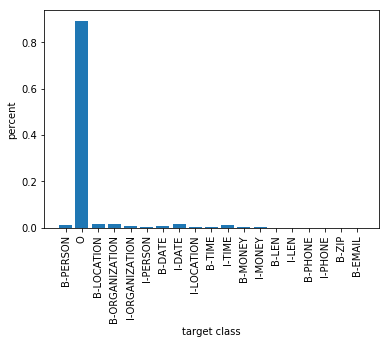

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import operator
from collections import defaultdict

count_target = defaultdict(lambda: 0)

for data_i in stack_sentences_01:
  for target_i in data_i[1]:
    count_target[target_i] += 1

percent = np.array(list(count_target.values()))
percent = percent/np.sum(percent)

plt.bar(range(len(count_target)), percent , align='center')
plt.xticks(range(len(count_target)), list(count_target.keys()),rotation='vertical')
plt.ylabel('percent')
plt.xlabel('target class')
plt.show()

# prepare data for training

In [0]:
x = []
y = []
set_y = set()

for data_i in stack_sentences_01:
  x.append(data_i[0])
  y.append(data_i[1])
  set_y.update(data_i[1])
print(len(set_y))

19


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## check statistic of data

In [0]:
import operator

words_train = set()
for x_i in X_train:
  words_train.update(x_i)
# count data 
from collections import defaultdict
count_words = defaultdict(lambda: 0)

for x_i in X_train:
  for words_x in x_i:
    count_words[words_x] += 1

sort_words = sorted(count_words.items(), key=operator.itemgetter(1))
sort_words.reverse()
# sort_words


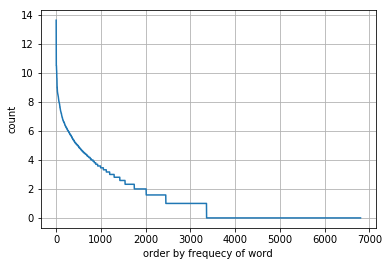

In [0]:
import numpy as np
import matplotlib.pyplot as plt
values = np.array([count[1] for count in sort_words])
plt.plot(np.arange(len(values)),np.log2(values))
plt.xlabel('order by frequecy of word')
plt.ylabel('count')
plt.grid(True)
plt.show()

In [0]:
# print(np.sum(np.log2(values) > 0))
sel_word = sort_words[:np.sum(np.log2(values) > 0)]
sel_word = [w[0] for w in sel_word]
# sel_word.insert(0, 'EOS')
sel_word = sorted(sel_word)
sel_word.append('UNK')

word2idx = {w:i for i,w in enumerate(sel_word)}
idx2word = {i:w for i,w in enumerate(sel_word)}

y_pros = list(set_y)
y_pros = sorted(y_pros)
label2idx = {w:i for i,w in enumerate(y_pros)}
idx2label = {i:w for i,w in enumerate(y_pros)}

X_train_ind =  [[word2idx[w] if (w in word2idx) else word2idx['UNK'] for w in sentence] for sentence in X_train]
#X_valid_ind =  [[word2idx[w] if (w in word2idx) else word2idx['UNK'] for w in sentence] for sentence in X_valid]
X_test_ind =  [[word2idx[w] if (w in word2idx) else word2idx['UNK'] for w in sentence] for sentence in X_test]

y_train_ind =  [[label2idx[t] if (t in label2idx) else label2idx['O'] for t in target] for target in y_train]
#y_valid_ind =  [[label2idx[t] if (t in label2idx) else label2idx['O'] for t in target] for target in y_valid]
y_test_ind =  [[label2idx[t] if (t in label2idx) else label2idx['O'] for t in target] for target in y_test]

364


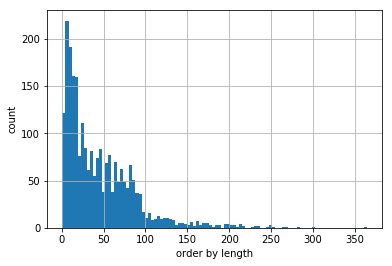

In [0]:
length_input = [len(sentence) for sentence in X_train ]
length_input = np.array(length_input)
maxlen_x = max(length_input)
print(maxlen_x)
plt.hist(length_input,bins = 100)
plt.xlabel('order by length')
plt.ylabel('count')
plt.grid(True)
plt.show()

---

## download library

In [0]:
!pip -qqq install git+https://www.github.com/keras-team/keras-contrib.git

In [0]:
import numpy as np
import numpy.random
import keras 
import tensorflow as tf
import tensorflow.keras.preprocessing
np.random.seed(42)
from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from keras_contrib.layers import CRF
from keras.optimizers import Adam
from keras.utils import to_categorical


## pre-processing data

In [0]:
x_train_tf = tf.keras.preprocessing.sequence.pad_sequences(X_train_ind, maxlen=120, dtype='int32', padding='post', truncating='pre', value=0.)
y_train_tf = tf.keras.preprocessing.sequence.pad_sequences(y_train_ind, maxlen=120, dtype='int32', padding='post', truncating='pre', value=0.)
y_train_tf = to_categorical(y_train_tf,len(y_pros))

# x_valid_tf = tf.keras.preprocessing.sequence.pad_sequences(X_test_ind, maxlen=120, dtype='int32', padding='post', truncating='pre', value=0.)
# y_valid_tf = tf.keras.preprocessing.sequence.pad_sequences(y_valid_ind, maxlen=120, dtype='int32', padding='post', truncating='pre', value=0.)
# y_valid_tf = to_categorical(y_valid_tf,len(y_pros))

x_test_tf = tf.keras.preprocessing.sequence.pad_sequences(X_test_ind, maxlen=120, dtype='int32', padding='post', truncating='pre', value=0.)
y_test_tf = tf.keras.preprocessing.sequence.pad_sequences(y_train_ind, maxlen=120, dtype='int32', padding='post', truncating='pre', value=0.)
y_test_tf = to_categorical(y_test_tf,len(y_pros))

# Simple classification model

input -> embedding layer (size 32) -> Bi-GRU (size 32) -> Dropout 20 %  -> TimeDistributed ( Dense size (number of class) ) -> output.

![alt text](https://sv1.picz.in.th/images/2019/09/19/c4cCFQ.md.png)

In [0]:
def get_simple_model():
  # put your code
  return pass                   
model_simple = get_simple_model()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 120, 32)           107552    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120, 64)           12480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120, 64)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 120, 19)           1235      
Total params: 121,267
Trainable params: 121,267
Non-trainable params: 0
_________________________________________________________________
None


<details>
    <summary>SOLUTION HERE!</summary>
      <pre>
        <code>
def get_simple_model():
  input1 = Input(shape=(120,))
  x = Embedding(len(word2idx),32,input_length=120)(input1)
  x = Bidirectional(GRU(32, return_sequences=True))(x)
  x = Dropout(0.2)(x)
  out = TimeDistributed(Dense(len(y_pros),activation='softmax'))(x)
  model1 = Model(input1, out)
  adam  = Adam(lr=0.001)
  model1.compile(optimizer=adam,  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print(model1.summary())                
  return model1 
        </code>
      </pre>
</details>

In [0]:
%%time
model_simple.fit(x_train_tf,y_train_tf,batch_size=64,epochs=10,verbose=1)

Epoch 1/10
2370/2370 [==============================] - 6s 3ms/step - loss: 2.3272 - categorical_accuracy: 0.6001
Epoch 2/10
2370/2370 [==============================] - 5s 2ms/step - loss: 0.6866 - categorical_accuracy: 0.7551
Epoch 3/10
2370/2370 [==============================] - 5s 2ms/step - loss: 0.3578 - categorical_accuracy: 0.9384
Epoch 4/10
2370/2370 [==============================] - 5s 2ms/step - loss: 0.2451 - categorical_accuracy: 0.9544
Epoch 5/10
2370/2370 [==============================] - 5s 2ms/step - loss: 0.2121 - categorical_accuracy: 0.9572
Epoch 6/10
2370/2370 [==============================] - 5s 2ms/step - loss: 0.1902 - categorical_accuracy: 0.9592
Epoch 7/10
2370/2370 [==============================] - 5s 2ms/step - loss: 0.1738 - categorical_accuracy: 0.9606
Epoch 8/10
2370/2370 [==============================] - 5s 2ms/step - loss: 0.1611 - categorical_accuracy: 0.9616
Epoch 9/10
2370/2370 [==============================] - 5s 2ms/step - loss: 0.1502 - cat

## create function for seeing evaluation result 

In [0]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [0]:
import pandas as pd
from IPython.display import display

def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set))
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)

In [0]:
y_pred = model_simple.predict(x_test_tf)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
evaluation_report(y_test_ind, ypred)

,tag,precision,recall,f_score,correct_count
0,0,6.26866,6.60377,6.43185,21
1,1,-,0,-,0
2,2,-,0,-,0
3,3,28.8889,1.8705,3.51351,13
4,4,-,0,-,0
5,5,25,0.277778,0.549451,2
6,6,30.2703,9.33333,14.2675,56
7,7,-,0,-,0
8,8,-,0,-,0
9,9,-,0,-,0


In [0]:
# y_pred=model.predict(x_test_tf)
# y_pred[0]

## crf model

In [0]:
K.clear_session()

In [0]:
from keras.models import Model, Input
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

# Write your code here
def get_crf_model():
  input1 = Input(shape=(120,))
  x = Embedding(len(word2idx),32,input_length=120)(input1)
  x = Bidirectional(GRU(32, return_sequences=True))(x)
  out = CRF(len(y_pros),sparse_target=True)(x)
  
  model = Model(input1, out)
  
  adam  = Adam(lr=0.001)
  model.compile(optimizer=adam,  loss=crf_loss, metrics=[crf_viterbi_accuracy])
  print(model.summary())
  return model 

model_crf = get_crf_model()
# %%time
model_crf.fit(x_train_tf,y_train_tf,batch_size=64,epochs=10,verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 120, 32)           107552    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 64)           12480     
_________________________________________________________________
crf_1 (CRF)                  (None, 120, 19)           1634      
Total params: 121,666
Trainable params: 121,666
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2370/2370 [==============================] - 11s 4ms/step - loss: 2.5590 - crf_viterbi_accuracy: 0.2833
Epoch 2/10
2370/2370 [==============================] - 9s 4ms/step - loss: 0.4950 - crf_viterbi_accuracy: 0.8383
Epoch 3/10
2370/2

In [0]:
y_pred = model_crf.predict(x_test_tf)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
evaluation_report(y_test_ind, ypred)

,tag,precision,recall,f_score,correct_count
0,0,0.732346,99.3711,1.45398,316
1,1,0,0,-,0
2,2,-,0,-,0
3,3,-,0,-,0
4,4,-,0,-,0
5,5,-,0,-,0
6,6,-,0,-,0
7,7,-,0,-,0
8,8,-,0,-,0
9,9,-,0,-,0


---

#python-crfsuite

In [0]:
!pip install python-crfsuite

     |████████████████████████████████| 757kB 3.5MB/s 


In [0]:
import pycrfsuite

In [0]:
def word2features(sent, i):
    word = sent[i]
    
    features = {
        'word': word,
        'word.isdigit': word.isdigit(),
        'word.length': len(word),
    }
    
    features['BOS'] = (i == 0)  # beginning of sentence
    features['EOS'] = (i == len(sent)-1)  # end of sentence
    
    return features

In [0]:
x_train_pycrf = [[word2features(sent,i) for i in range(len(sent))] for sent in X_train]
x_test_pycrf = [[word2features(sent,i) for i in range(len(sent))] for sent in X_test]

**trainer** 

In [0]:
trainer = pycrfsuite.Trainer(verbose=False)
for xseq, yseq in zip(x_train_pycrf, y_train):
    trainer.append(xseq, yseq)

In [0]:
trainer.params()

['feature.minfreq',
 'feature.possible_states',
 'feature.possible_transitions',
 'c1',
 'c2',
 'max_iterations',
 'num_memories',
 'epsilon',
 'period',
 'delta',
 'linesearch',
 'max_linesearch']

In [0]:
trainer.set_params({
    'max_iterations': 100,
    'feature.possible_transitions': True,
    'feature.possible_states': True,
})

In [0]:
%%time
model_path = 'crf_basic.model'
trainer.train(model_path)

CPU times: user 22.7 s, sys: 25.1 ms, total: 22.8 s
Wall time: 22.8 s


In [0]:
!ls

crf_basic.model  __MACOSX     thai_ner-08072018-14-01.raw.conll
gdrive		 sample_data  thai_ner-11072018-21-14.raw.conll


**making prediction**

In [0]:
tagger = pycrfsuite.Tagger()
tagger.open(model_path)

In [0]:
idx_sample = 5
example_sent = X_test[idx_sample]
corr_output_example_sent = y_test[idx_sample]
print('_'.join(example_sent))
x_sample_pycrf = [word2features(example_sent,i) for i in range(len(example_sent))]
print('Predicted: ', ' '.join(tagger.tag(x_sample_pycrf)))
print('Correct: ', ' '.join(corr_output_example_sent))

เมื่อ_วัน_ที่_ _13_ _พ.ค._ _ที่_ทำเนียบรัฐบาล_ _นายวิษณุ เครืองาม_ _รอง_นายก_รัฐมนตรี_ _กล่าว_ถึง_กรณี_นายไพบูลย์ นิติตะวัน_ _สมาชิก_ _สปช._ใน_ฐานะ_ _กมธ._ยก_ร่าง_รัฐธรรมนูญ_เสนอ_ให้_มี_การ_แก้ไข_รัฐธรรมนูญ_ _มาตรา_ _308_ _เพื่อ_ทำ_ประชามติ_สอบถาม_ประชาชน_ว่า_ _ควร_ปฏิรูป_ _2_ _ปี_ก่อน_การ_เลือกตั้ง_หรือ_ไม่
Predicted:  O O O O O O O O O O O B-ORGANIZATION O O O O O O O O B-ORGANIZATION O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
Correct:  O O O O B-DATE I-DATE I-DATE O O B-LOCATION O B-PERSON I-PERSON I-PERSON I-PERSON I-PERSON O O O O B-PERSON O O B-ORGANIZATION I-ORGANIZATION O O O B-ORGANIZATION I-ORGANIZATION I-ORGANIZATION I-ORGANIZATION O O O O O O O O O O O O O O O O O O O O O B-DATE I-DATE I-DATE O O O O O


In [0]:
y_pred = [tagger.tag(x_sent) for x_sent in x_test_pycrf]
evaluation_report(y_test, y_pred)

,tag,precision,recall,f_score,correct_count
0,B-DATE,76.6667,20.7831,32.7014,69
1,B-EMAIL,-,0,-,0
2,B-LEN,-,0,-,0
3,B-LOCATION,50,3.41207,6.38821,26
4,B-MONEY,100,20,33.3333,11
5,B-ORGANIZATION,40.5594,23.6092,29.8456,174
6,B-PERSON,56.338,19.6399,29.1262,120
7,B-PHONE,-,0,-,0
8,B-TIME,95.7627,61.7486,75.0831,113
9,B-ZIP,-,0,-,0
